This example is a rip-off of the official documentation : [Working With Text Data — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#tokenizing-text-with-scikit-learn)

In [1]:
# %load https://gist.githubusercontent.com/kidpixo/2ec078d09834b5aa7869/raw/350f79fe4f2e09592404a76db18dcc01a961444b/ipython_inizialization.py
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth',120)
pd.set_option('display.max_rows',300)

## my new favourite :
from IPython.display import display

In [2]:
labelled = pd.read_csv('training.csv',sep=',')
unknown = pd.read_csv('unknown.csv',sep=',')

In [3]:
## German 
cols = ['Empfänger/Zahlungspflichtiger','Kategorie 1'] # all the columns relevant to this analysis
text_col = ['Empfänger/Zahlungspflichtiger']           # the "data" column
target_col = ['Kategorie 1']                           # the target column

# ## English
# cols = ['Recipient / Payer','Category 1'] # all the columns relevant to this analysis
# text_col = ['Recipient / Payer']          # the "data" column
# target_col = ['Category 1']               # the target column

print('labelled : {}, unknown : {} '.format(labelled.shape[0],unknown.shape[0]))
print('Features : ', text_col)
print('Target : ', target_col)

labelled : 236, unknown : 186 
Features :  ['Empfänger/Zahlungspflichtiger']
Target :  ['Kategorie 1']


In [4]:
display(labelled[cols].sample(5))
print()
display(unknown[cols].sample(5))

,Empfänger/Zahlungspflichtiger,Kategorie 1
225,Foodwatch e.V.,Spenden
1,Degussa Bank AG,Bargeld
155,Kerstin Stahler,Geschenke
187,Dorotheenstadt Apotheke,Gesundheit
172,Paysafe Financial ServicesLimited,Sport


,Empfänger/Zahlungspflichtiger,Kategorie 1
171,IKEA 129 WALTERSDORF,NaN
94,Lastschrift aus Kartenzahlung,NaN
90,VOLKSWOHL BUND Lebensversicherung a.G.,NaN
181,Bausparkasse Schwaebisch Hall Aktiengesellschaft - Bau,NaN
19,KUTZNER UND KUTZNER,NaN


In [25]:
# Extracting features from text files
## Tokenizing text with scikit-learn

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# model 1
from sklearn.naive_bayes import MultinomialNB
# model 2
from sklearn.linear_model import SGDClassifier

# paramters gris search
from sklearn.model_selection import GridSearchCV

`extraxt_str` is a dumb attempt of cutting out some recurrent stuff in text fields, like receipt/order number, recurring not significative text and so on. 

It should be properly implemented via [Natural Language Toolkit (NLTK)](https://www.nltk.org/) :

* [Stemming - Wikipedia](https://en.wikipedia.org/wiki/Stemming)
* [NLP Tutorial Using Python NLTK (Simple Examples) - DZone AI](https://dzone.com/articles/nlp-tutorial-using-python-nltk-simple-examples)
* [https://www.nltk.org/book/ch03.html](https://www.nltk.org/book/ch03.html)

In [7]:
def extraxt_str(text):
    import re
    text =  re.sub(r'[0-9]+', ' ', text)
    text =  re.sub(r'Basislastschrift', '', text)
    text =  re.sub(r'[/\+\.:]+', ' ', text)
    text =  re.sub(r'IBAN', '', text)
    text =  re.sub(r'BIC', '', text)
    text =  re.sub(r'FPIN', '', text)
    text =  re.sub(r'REF', '', text)
    text =  re.sub(r'CICC', '', text)
    text =  re.sub(r'ZZZ', '', text)
    text =  re.sub(r'\s+', ' ', text)
#     text = re.sub(r'\W', ' ', str(X[sen]))     # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)     # remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from the start
    text = text.lower()    # Converting to Lowercase

#     text = text.split()     # Lemmatization : here we need NLTK to strip common words
    return text 


## Define the data

To teach the model we need to define the training and the target  data

- `labelled_text` : our traning data
- `labelled_target` : our target data, or the labels

We will split the traning labelled data to measure the generalisation performances of the models.

In [6]:
labelled_text = labelled.dropna(subset=text_col)[text_col].values[:,0]
## Having more columns one could mix and match them to extend the feature space
# labelled_text = (labelled.dropna(subset=text_col)[text_col[0]]+' '+ labelled.dropna(subset=text_col)[text_col[1]].apply(extraxt_str)).values.tolist()
labelled_target = labelled.dropna(subset=text_col)[target_col].values[:,0]

labelled_text_train, labelled_text_test, \
labelled_target_train, labelled_target_test = \
        train_test_split(labelled_text, labelled_target,test_size=0.05, random_state=42)

print('Original Data Train/Test : {}/{}\n'
      '  Split-Train Train/Test : {}/{}\n'
      '   Split-Test Train/Test : {}/{}'.format(
        labelled_text.shape[0], labelled_target.shape[0], \
        labelled_text_train.shape[0], labelled_target_train.shape[0], \
        labelled_text_test.shape[0], labelled_target_test.shape[0]))



Original Data Train/Test : 236/236
  Split-Train Train/Test : 224/224
   Split-Test Train/Test : 12/12


### Machines are learning

For user learning sake (sorry for the pun) we can :

- pre-process
- instanciate
- fit
- predict

each single model.


This exact pattern applies to each new model, below we will streamline it.

In [20]:
count_vect = CountVectorizer()

# From occurrences to frequencies
labelled_count_vec = count_vect.fit_transform(labelled_text)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(labelled_count_vec)

#### Model 1 : Multinomial Naive Bayes > https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
clf = MultinomialNB().fit(X_train_tfidf, labelled_target)

predictor = lambda x : clf.predict(tfidf_transformer.transform(count_vect.transform(x)))

print('MultinomialNB')
print ('{:<15}{:<15}\n{:<15f}{:<15f}'.format('Train Score','Test Score' ,\
                      np.mean(predictor(labelled_target_train) == labelled_target_train),\
                      np.mean(predictor(labelled_text_test) == labelled_target_test)))

# print all the input (data,classes, predictions)
# display(list(zip(labelled_target_test,labelled_text_test,predictor(labelled_text_test))))

### Model 2 : SGDClassifier > https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,
                    random_state=42,max_iter=100, 
                    tol=1e-1).fit(X_train_tfidf, labelled_target)

predictor = lambda x : clf.predict(tfidf_transformer.transform(count_vect.transform(x)))

print('SGDClassifier')
print ('{:<15}{:<15}\n{:<15f}{:<15f}'.format('Train Score','Test Score' ,\
                      np.mean(predictor(labelled_target_train) == labelled_target_train),\
                      np.mean(predictor(labelled_text_test) == labelled_target_test)))


# print all the input (data,classes, predictions)
# display(list(zip(labelled_target_test,labelled_text_test,predictor(labelled_text_test))))

MultinomialNB
Train Score    Test Score     
0.303571       0.666667       
SGDClassifier
Train Score    Test Score     
0.058036       0.916667       


### Machines are learning with Pipelines

In [21]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1e-3)),
])

text_clf.fit(labelled_text_train, labelled_target_train)

print ('{:<15}{:<15}\n{:<15f}{:<15f}'.format('Train Score','Test Score' ,\
                      np.mean(text_clf.predict(labelled_target_train) == labelled_target_train),\
                      np.mean(text_clf.predict(labelled_text_test) == labelled_target_test)))

# display(list(zip(labelled_target_test,labelled_text_test,text_clf.predict(labelled_text_test))))

Train Score    Test Score     
0.303571       0.750000       


In [26]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', 
                          alpha=1e-3, random_state=42,
                          max_iter=100, tol=1e-3)),
])

text_clf.fit(labelled_text_train, labelled_target_train)

print ('{:<15}{:<15}\n{:<15f}{:<15f}'.format('Train Score','Test Score' ,\
                      np.mean(text_clf.predict(labelled_target_train) == labelled_target_train),\
                      np.mean(text_clf.predict(labelled_text_test) == labelled_target_test)))

# display(list(zip(labelled_target_test,labelled_text_test,text_clf.predict(labelled_text_test))))

Train Score    Test Score     
0.071429       0.750000       


### Machines are learning with Paramters Grid-search

Search for the best tuning parameters for the model.

This could be computationally expensive!!

In [33]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-1, 1e-5), # regularisation paramter == model flexibility
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, iid=False, n_jobs=-1)
# labelled_text_train.shape, labelled_target_train.shape
gs_clf = gs_clf.fit(labelled_text_train, labelled_target_train)

gs_clf.best_score_                                  

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

/Users/damo_ma/.virtualenvs/mascs_analysis/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


clf__alpha: 1e-05
tfidf__use_idf: True
vect__ngram_range: (1, 2)


In [39]:
# already fitted + optimised text_clf 
text_clf = gs_clf.best_estimator_

print ('{:<15}{:<15}\n{:<15f}{:<15f}'.format('Train Score','Test Score' ,\
                      np.mean(text_clf.predict(labelled_target_train) == labelled_target_train),\
                      np.mean(text_clf.predict(labelled_text_test) == labelled_target_test)))

# display(list(zip(labelled_target_test,labelled_text_test,text_clf.predict(labelled_text_test))))

Train Score    Test Score     
0.089286       0.666667       


### Visualise the Models confusion

Confusion matrix, without normalization


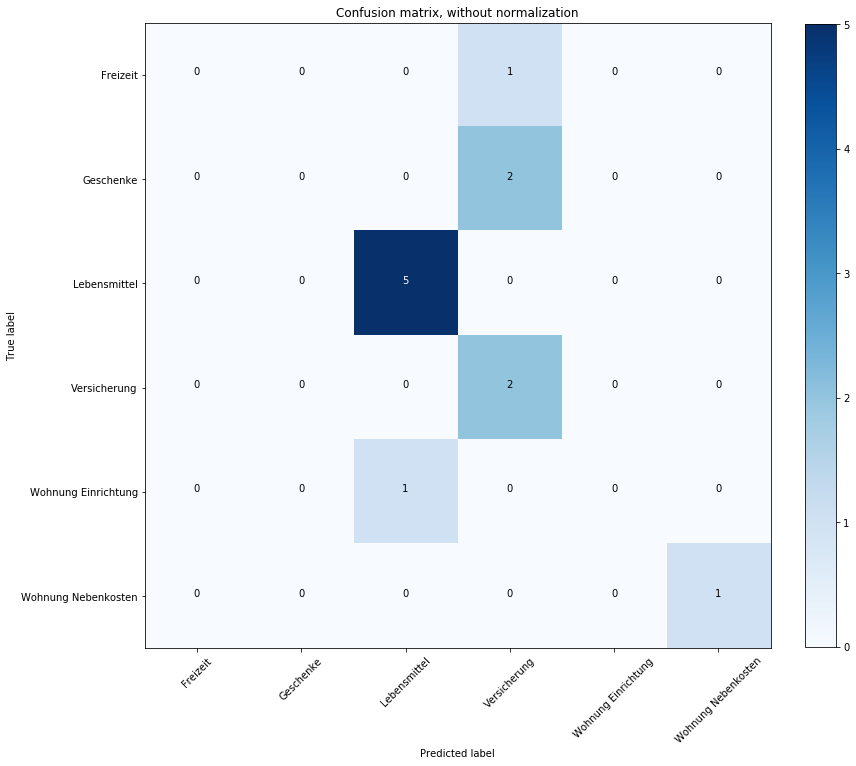

In [40]:
from sklearn import metrics
# print(metrics.classification_report(labelled_target_test, text_clf.predict(labelled_text_test)))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.045)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = metrics.confusion_matrix(labelled_target_test, text_clf.predict(labelled_text_test))

# Plot un-normalized confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(labelled_target_test),title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure(figsize=(16,16))
# plot_confusion_matrix(cnf_matrix, classes=np.unique(labelled_target_test), normalize=True,title='Normalized confusion matrix')


In [43]:
unknown_text = unknown.dropna(subset=text_col)[text_col[0]].values
# unknown_text = (unknown.dropna(subset=text_col)[text_col[0]]+' '+ unknown.dropna(subset=text_col)[text_col[1]].apply(extraxt_str)).values

# assign the classes
unknown.loc[unknown.dropna(subset=text_col).index,'predicted'] = text_clf.predict(unknown_text) 
unknown[text_col+target_col+['predicted']].head()

# write the unknown data back with the new predicted column

,Empfänger/Zahlungspflichtiger,Kategorie 1,predicted
0,RESTAURANT SPEISEHAUS,NaN,Freizeit
1,"PayPal (Europe) S.a.r.l. etCie., S.C.A.",NaN,Lebensmittel
2,LOGPAY FINANCIAL SERVICES GMBH,NaN,Sport
3,LOGPAY FINANCIAL SERVICES GMBH,NaN,Sport
4,DHL Onlinefrankierung,NaN,Versicherung
